We shall start by importing the essential libraries.

In [1]:
### IMPORTING LIBRARIES
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import collections
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import plot_confusion_matrix, classification_report, accuracy_score, recall_score, roc_curve, roc_auc_score
from sklearn.linear_model import LogisticRegression

Next, we clean the data and bring it to a form which will make the model building process easy. This phase is done exactly the same way as in 00 - Stroke EDA.

In [2]:
### DATA PREPARATION
stroke = pd.read_csv('C:\\Users\\Shekhar Lamba\\Documents\\Datasets\\healthcare-dataset-stroke-data.csv', na_values = [np.NaN, ' '])

df = pd.DataFrame(stroke)
df = df.drop(['id'], axis = 1)

num_vars = df.select_dtypes(include = ['int64', 'float64'])
cat_vars = df.select_dtypes(include = 'object')
feature_names = collections.defaultdict(str)
for name in num_vars.columns:
    feature_names[name]
for name in cat_vars.columns:
    feature_names[name]

mean_imputer = SimpleImputer(strategy = 'mean')
imputed_vars = mean_imputer.fit_transform(num_vars)
df_imputed = pd.DataFrame(np.hstack([imputed_vars, cat_vars]), columns = feature_names)

df_imputed['age'] = df_imputed['age'].astype('float64')
df_imputed['hypertension'] = df_imputed['hypertension'].astype('int64')
df_imputed['heart_disease'] = df_imputed['heart_disease'].astype('int64')
df_imputed['avg_glucose_level'] = df_imputed['avg_glucose_level'].astype('float64')
df_imputed['bmi'] = df_imputed['bmi'].astype('float64')
df_imputed['stroke'] = df_imputed['stroke'].astype('int64')

capping = num_vars.select_dtypes(include = 'float64')
for col in df_imputed.columns:
    if col in capping.columns:
        percentile = df_imputed[col].quantile([0.05, 0.95]).values
        df_imputed[col] = df_imputed[col].clip(lower = percentile[0], upper = percentile[1])
        
df_final = pd.get_dummies(df_imputed, columns = ['gender', 'ever_married', 'work_type', 'Residence_type',
                                              'smoking_status'], drop_first = True)

Now we separate the independent and dependent features; we label them X and y respectively. Then, we separate data for training and testing sets in the ratio of 8:2, making sure that the imbalance in the levels of the target variable, y, is maintained in both the sets. In other words, both the training and testing sets have the same proportion of people who did not suffer from stroke and those who did.

In [3]:
### SEPARATING TRAIN AND TEST SETS
X = df_final.drop(['stroke'], axis = 1)
y = df_final['stroke']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.2, random_state = 99)

We now go on to make a simple Logistic Regression model, which will serve as our baseline. Remember that the data was highly unbalanced in that the number of people who did not suffer from stroke was far more than those who did. To overcome this problem, we simply set the weights of the levels of y as balanced. What this does is that it assigns weights to the two levels of y, the weight of each level being inversely proportional to its frequency.


So, we build the model with class weights as balanced and set the maximum number of iterations to 1000. We fit the training data and plot the confusion matrix.

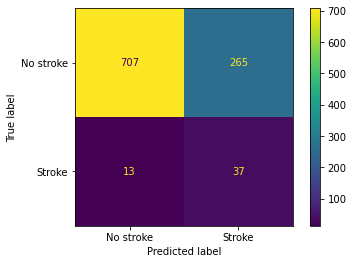

In [4]:
### CREATING A BASELINE MODEL
clf_logit = LogisticRegression(random_state = 99, class_weight = 'balanced', max_iter = 1000)
clf_logit.fit(X_train, y_train)
plot_confusion_matrix(clf_logit, X_test, y_test, display_labels = ['No stroke', 'Stroke'])

Before we proceed, let's take a look at the distribution of the levels of y in our dataset.

In [5]:
df['stroke'].value_counts(normalize = True)

0    0.951272
1    0.048728
Name: stroke, dtype: float64

Here, we see that around 95% of the people in our dataset have not suffered from stroke as opposed to just about 5% who actually have. This means that even if our model predicts every person as not having a stroke, the model will still be 95% accurate at the very least. So, in this case, accuracy is a deceptive metric. 


What we should rather be concerned with is the number of people who actually had stroke but were not identified by the model as having stroke i.e. the False Negatives. Lower the FN value, lower is the risk of overlooking a possible case of stroke and thus better is the model because the main objective of the model here should be to possibly save lives by correctly identifying a stroke case as early as possible. To reduce the FN value, we need to ensure that the recall of stroke cases is high since recall and FN are inversely proportional.


So, we shall calculate the accuracy and recall values for the predictions made by the model.

In [6]:
### CALCULATING ESSENTIAL METRICS 
y_pred_logit = clf_logit.predict(X_test)
print(classification_report(y_test, y_pred_logit, target_names = ['No stroke', 'Stroke']))
print('Accuracy: %f' % accuracy_score(y_test, y_pred_logit))
print('Recall score: %f' % recall_score(y_test, y_pred_logit))

              precision    recall  f1-score   support

   No stroke       0.98      0.73      0.84       972
      Stroke       0.12      0.74      0.21        50

    accuracy                           0.73      1022
   macro avg       0.55      0.73      0.52      1022
weighted avg       0.94      0.73      0.81      1022

Accuracy: 0.727984
Recall score: 0.740000


If we look at the confusion matrix, we see that out of the 50 cases that had actually suffered from stroke, 37 were correctly predicted as having a stroke by our model while 13 were overlooked. This gives us a recall score of 74% while the accuracy is about 73%.

Next, we plot the ROC curve and calculate the AUC score.

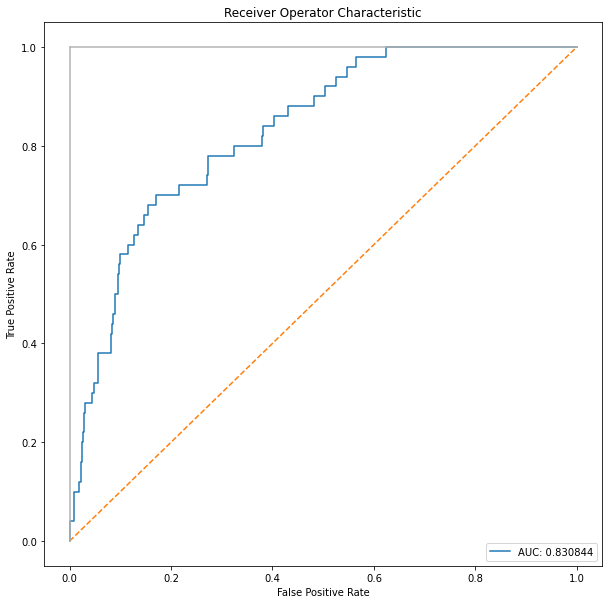

In [7]:
### PLOTTING ROC CURVE WITH AUC VALUE
y_prob_logit = clf_logit.predict_proba(X_test)[:, 1]
fpr, tpr, threshold = roc_curve(y_test, y_prob_logit)
roc_auc = roc_auc_score(y_test, y_prob_logit)
plt.figure(figsize = (10, 10))
plt.title('Receiver Operator Characteristic')
plt.plot(fpr, tpr, label = 'AUC: %f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], ls = '--')
plt.plot([0, 0], [1, 0], c = '0.7')
plt.plot([1, 1], c = '0.7')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

We get an AUC score of about 0.8308. 


Now that we have our baseline model, let us try to improve on it by introducing regularization. Regularization reduces the effect of individual points thereby decreasing the variance of the model. But first, let us scale the values of the continuous variables in our dataset so that they are in the same range.

In [8]:
### SCALING CONTINUOUS VARIABLES
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

For our improved Logistic Regression model, we shall introduce parameters solver and C. A solver is essentially an algorithm that will be used for optimization. We shall use liblinear, which stands for Library for Large Linear Classification and uses the coordinate descent algorithm. C is a hyperparameter and it is the inverse of the regularization penalty; thus lower the value of C, higher is the regularization penalty. We randomly set C to 1 and check our model. 

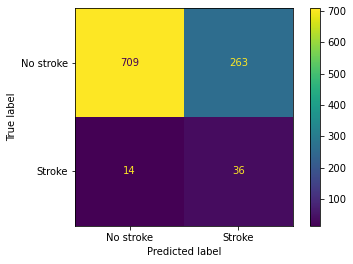

In [9]:
### CREATING A REGULARIZED MODEL
clf_logit = LogisticRegression(random_state = 99, solver = 'liblinear', C = 1, class_weight = 'balanced')
clf_logit.fit(X_train_scaled, y_train)
plot_confusion_matrix(clf_logit, X_test_scaled, y_test, display_labels = ['No stroke', 'Stroke'])

Of the 50 stroke cases, 36 were correctly identified by the new model while 14 were mislabelled. This is actually worse than our baseline model.

In [10]:
### CALCULATING ESSENTIAL METRICS
y_pred_logit = clf_logit.predict(X_test_scaled)
print(classification_report(y_test, y_pred_logit, target_names = ['No stroke', 'Stroke']))
print('Accuracy: %f' % accuracy_score(y_test, y_pred_logit))
print('Recall: %f' % recall_score(y_test, y_pred_logit))

              precision    recall  f1-score   support

   No stroke       0.98      0.73      0.84       972
      Stroke       0.12      0.72      0.21        50

    accuracy                           0.73      1022
   macro avg       0.55      0.72      0.52      1022
weighted avg       0.94      0.73      0.81      1022

Accuracy: 0.728963
Recall: 0.720000


Again, we can see that the new model does worse since the recall score reduced by 2% from our baseline model while the accuracy showed a slight improvement, pointing to the already established fact that accuracy is a deceptive metric in this case.

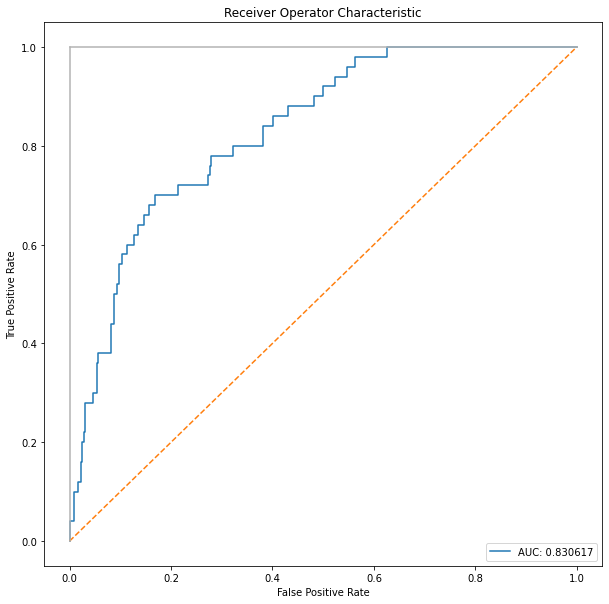

In [11]:
### PLOTTING ROC CURVE WITH AUC VALUE
y_prob_logit = clf_logit.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, threshold = roc_curve(y_test, y_prob_logit)
roc_auc = roc_auc_score(y_test, y_prob_logit)
plt.figure(figsize = (10, 10))
plt.title('Receiver Operator Characteristic')
plt.plot(fpr, tpr, label = 'AUC: %f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], ls = '--')
plt.plot([0, 0], [1, 0], c = '0.7')
plt.plot([1, 1], c = '0.7')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

We also see that AUC score has slightly decreased.


Although the new model seems worse than the baseline, we will try to improve it by tuning it's hyperparameters. For this, we shall use a grid search across possible values for the hyperparameters C and penalty. We create a pipeline which first separates and scales some portion of the training data, then uses it to create a model which will test on the remaining data; we will do this 10 times over via 10 fold cross-validation. As we are trying to decrease the FN value, we will use roc_auc as our scoring parameter.

In [12]:
### TUNING HYPERPARAMETER VALUES USING GRID SEARCH
logit = LogisticRegression(random_state = 99, solver = 'liblinear', class_weight = 'balanced')
scaler = StandardScaler()
pipe = Pipeline([('scaler', scaler), ('classifier', logit)])
search_space = [{'classifier__C': [0.00001, 0.00005, 0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5,
                                  1, 5, 10, 15, 20, 25, 30, 50, 100],
                'classifier__penalty': ['l1', 'l2']}]
grid_fit = GridSearchCV(pipe,
                        search_space,
                        scoring = 'roc_auc',
                        cv = 10,
                        verbose = 2,
                        n_jobs = -1)
best_model = grid_fit.fit(X_train, y_train)
print('Best C value: %f' % best_model.best_estimator_.get_params()['classifier__C'])
print('Best penalty: %s' % best_model.best_estimator_.get_params()['classifier__penalty'])

Fitting 10 folds for each of 42 candidates, totalling 420 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    4.8s


Best C value: 0.010000
Best penalty: l1


[Parallel(n_jobs=-1)]: Done 420 out of 420 | elapsed:   10.8s finished


Now, with these tuned hyperparameter values, we shall create our final Logistic Regression model.

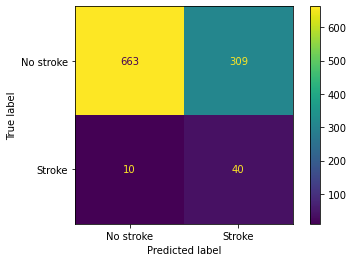

In [13]:
### CREATING THE FINAL MODEL
clf_logit = LogisticRegression(random_state = 99, solver = 'liblinear', C = 0.01, penalty = 'l1', class_weight = 'balanced')
clf_logit.fit(X_train_scaled, y_train)
plot_confusion_matrix(clf_logit, X_test_scaled, y_test, display_labels = ['No stroke', 'Stroke'])

Of the 50 stroke cases, the final model predicts 40 correctly while it fails to do the same for the other 10. 

In [14]:
### CALCULATING ESSENTIAL METRICS
y_pred_logit = clf_logit.predict(X_test_scaled)
print(classification_report(y_test, y_pred_logit, target_names = ['No stroke', 'Stroke']))
print('Accuracy: %f' % accuracy_score(y_test, y_pred_logit))
print('Recall: %f' % recall_score(y_test, y_pred_logit))

              precision    recall  f1-score   support

   No stroke       0.99      0.68      0.81       972
      Stroke       0.11      0.80      0.20        50

    accuracy                           0.69      1022
   macro avg       0.55      0.74      0.50      1022
weighted avg       0.94      0.69      0.78      1022

Accuracy: 0.687867
Recall: 0.800000


The recall score has gone up to 80% which makes this model the best one so far. Also, keep in mind that the accuracy has gone down to about 69%. Still, this final model works better in terms of not missing out on possible stroke cases and thus seems ideal for the scenario.

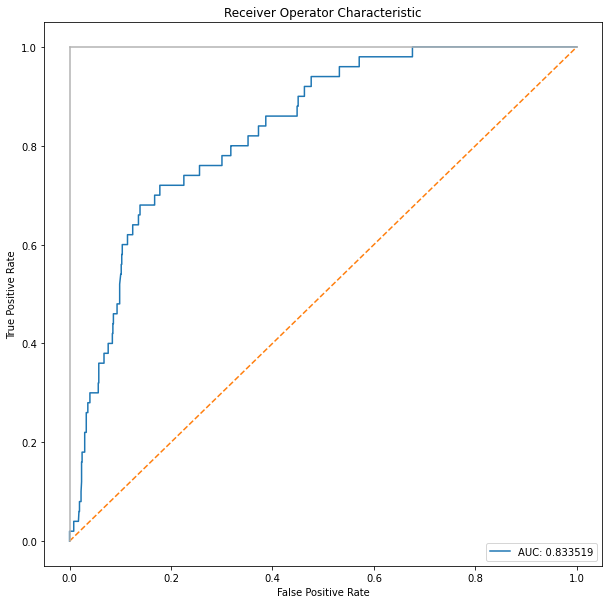

In [15]:
### PLOTTING ROC CURVE WITH AUC VALUE
y_prob_logit = clf_logit.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, threshold = roc_curve(y_test, y_prob_logit)
roc_auc = roc_auc_score(y_test, y_prob_logit)
plt.figure(figsize = (10, 10))
plt.title('Receiver Operator Characteristic')
plt.plot(fpr, tpr, label = 'AUC: %f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], ls = '--')
plt.plot([0, 0], [1, 0], c = '0.7')
plt.plot([1, 1], c = '0.7')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

Finally, the AUC score for this model is 0.8335, which is more than it's predecessors. This further proves our case for the final model being the best Logistic Regression model out of the three.